In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

# MSE Imports
import kepler_sieve
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

Found 4 GPUs.  Setting memory growth = True.


In [2]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

In [4]:
# Color for plots
color_mean = 'blue'
color_lo = 'orange'
color_hi = 'green'
color_min = 'red'
color_max = 'purple'

## Load ZTF Data and Batch of Orbital Elements

In [5]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [6]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [7]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [8]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [9]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [10]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [11]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [12]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [13]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [14]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [15]:
# Mixture parameters
num_hits: int = 20
R_deg: float = 0.5

In [16]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, score_by_elt=score_by_elt, num_hits=num_hits, R_deg=R_deg)

In [17]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [18]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,h,R
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,0.001573,0.008727
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,0.001681,0.008727
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,0.001591,0.008727
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,0.002034,0.008727
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,0.002191,0.008727
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,0.002207,0.008727
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,0.001961,0.008727
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,0.002985,0.008727
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,0.004413,0.008727


## Train on Random Elements: Learn Mixture Parameters

In [19]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [20]:
# Training parameters
learning_rate = 2.0**-15
clipnorm = 1.0

In [21]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [22]:
# Report before training starts
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :     1.99  :   0.00 :  0.500000 :  1800.00 : 2.000000
Std  :     0.99  :   0.00 :  0.000000 :     0.00 : 0.000000
Min  :     0.44  :   0.00 :  0.500000 :  1800.00 : 2.000000
Max  :     5.09  :   0.00 :  0.500000 :  1800.00 : 2.000000


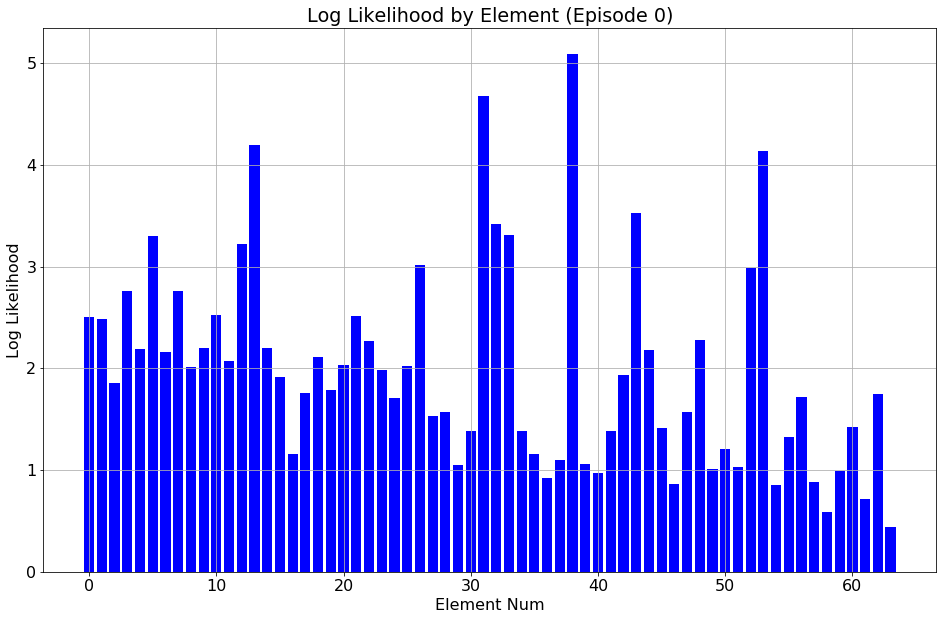

In [23]:
# Visualize log likelihood before traning
fig, ax = model.plot_bar('log_like', sorted=False)

In [24]:
# Adaptive search parameters
max_batches_mixture = 2000
max_batches_element = 10000
batches_per_epoch = 100
epochs_per_episode = 5
thresh_deg_end = None
max_bad_episodes = 3
min_learning_rate = None
save_at_end = False
reset_active_weight = False
verbose = 1

In [25]:
# # Load model
# model.load()
# model.report()

In [26]:
# Preliminary round of training with frozen elements
model.freeze_candidate_elements()

In [27]:
# Train perturbed model with frozen orbital elements
model.search_adaptive(
    max_batches=max_batches_mixture, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 0: Epoch    0, Batch      0
effective_learning_rate=3.052e-05, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 5s 718us/sample - loss: -623.2596
Epoch 2/5
6400/6400 [==============================] - 2s 381us/sample - loss: -1084.8423
Epoch 3/5
6400/6400 [==============================] - 2s 383us/sample - loss: -1537.7926
Epoch 4/5
6400/6400 [==============================] - 2s 380us/sample - loss: -1973.5192
Epoch 5/5
6400/6400 [==============================] - 3s 394us/sample - loss: -2384.3176
Adjusted element weight down on 1 candidate elements. Mean weight = 9.92e-01
Geom Mean Resolution: 0.435899 degrees (1569.2 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:      9.88

Training episode 1: Epoch    5, Batch    500
effective_learning_rate=3.028e-05, training_time 73 sec.
Train on 6400 samples
Epoch 6/10
6400/6400 [==============================] - 3s 393us/sample - loss: -2733.8675
Epoch 7/10
6

In [28]:
# Report after initial training on mixture parameters
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    12.93  :   0.00 :  0.429039 :  1544.54 : 2.000000
Std  :     8.79  :   0.00 :  0.048644 :   175.12 : 0.000000
Min  :     0.58  :   0.00 :  0.340730 :  1226.63 : 2.000000
Max  :    32.54  :   0.00 :  0.565534 :  2035.92 : 2.000000


In [29]:
model.freeze_score()

In [30]:
# Save model
model.save_state()

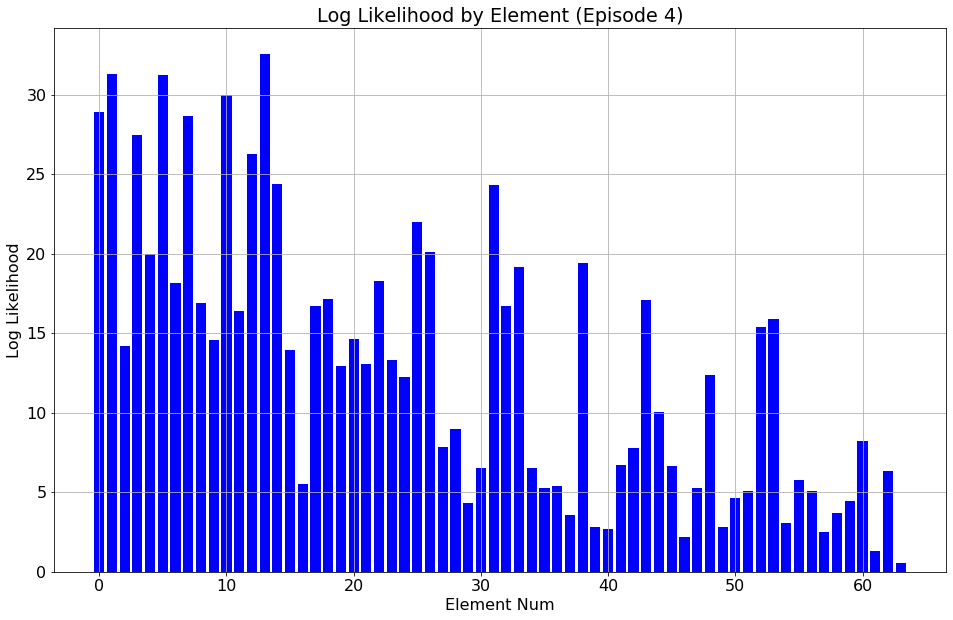

In [31]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [32]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('hits', sorted=False)

In [34]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [36]:
# # Threshold in degrees
# fig, ax = model.plot_bar('thresh_deg_score', sorted=False)

## Train on Orbital Elements & Mixture Parameters

In [37]:
# Unfreeze the elements
model.thaw_candidate_elements()

In [43]:
# Train in joint mode; learn elements, mixture_parameters; threshold frozen
model.search_adaptive(
    max_batches=model.current_batch+10000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    thresh_deg_end=1.0,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=1.138e-05, training_time 112 sec.
Updating thresh_deg. episode_batch 0 / 10000 ( 0.0%); thresh_deg = 2.000000 (factor 1.000000 from start).
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 5s 763us/sample - loss: -8157.7181
Epoch 22/25
6400/6400 [==============================] - 3s 494us/sample - loss: -10373.7043
Epoch 23/25
6400/6400 [==============================] - 3s 488us/sample - loss: -11875.3417
Epoch 24/25
6400/6400 [==============================] - 3s 494us/sample - loss: -13084.6332
Epoch 25/25
6400/6400 [==============================] - 3s 494us/sample - loss: -14112.1951
Geom Mean Resolution: 0.352532 degrees (1269.1 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:    141.47

Training episode 5: Epoch   25, Batch   2500
effective_learning_rate=1.138e-05, training_time 466 sec.
Updating thresh_deg. episode_batch 500 / 10000 ( 5.0%); thresh_deg = 1.931872 

In [44]:
# Report after training
model.report()

     \  log_like :  hits  :  R_deg    :    R_sec : thresh_deg
Mean :    47.79  :   0.00 :  0.465867 :  1677.12 : 1.035265
Std  :    29.84  :   0.00 :  0.111777 :   402.40 : 0.000000
Min  :    -2.51  :   0.00 :  0.200121 :   720.44 : 1.035265
Max  :   132.15  :   0.00 :  0.705284 :  2539.02 : 1.035265


In [48]:
# model.save_state()

In [50]:
# Unfreeze the elements
model.freeze_candidate_elements()
model.thaw_score()

In [51]:
model.search_adaptive(
    max_batches=model.current_batch+2000, 
    batches_per_epoch=batches_per_epoch,
    epochs_per_episode=epochs_per_episode,
    reset_active_weight=reset_active_weight,
    verbose=verbose)


Training episode 24: Epoch  120, Batch  12000
effective_learning_rate=4.228e-06, training_time 821 sec.
Train on 6400 samples
Epoch 121/125
6400/6400 [==============================] - 4s 622us/sample - loss: -2684.8019
Epoch 122/125
6400/6400 [==============================] - 3s 470us/sample - loss: -2717.1822
Epoch 123/125
6400/6400 [==============================] - 3s 472us/sample - loss: -2742.3575
Epoch 124/125
6400/6400 [==============================] - 3s 460us/sample - loss: -2763.4593
Epoch 125/125
6400/6400 [==============================] - 3s 466us/sample - loss: -2780.8710
Adjusted element weight down on 43 candidate elements. Mean weight = 2.32e-01
Geom Mean Resolution: 0.454032 degrees (1634.5 arc seconds)
Mean Hits          :      0.00
Mean Log Likelihood:     48.61

Training episode 25: Epoch  125, Batch  12500
effective_learning_rate=7.093e-06, training_time 969 sec.
Train on 6400 samples
Epoch 126/130
6400/6400 [==============================] - 3s 465us/sample -

In [ ]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=True)

## Extended Training

In [ ]:
max_batches_element_2 = 15000

In [ ]:
# # Train unperturbed model in joint mode
# model.search_adaptive(
#     max_batches=max_batches_element_2, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     learning_rate=learning_rate,
#     save_at_end=False,
#     verbose=verbose)

In [ ]:
# model.report()

In [ ]:
# model.save_state()

In [ ]:
# model.search_adaptive(
#     max_batches=100000, 
#     batches_per_epoch=batches_per_epoch,
#     epochs_per_episode=epochs_per_episode,
#     learning_rate=2.0**-16,
#     reset_active_weight=True,
#     save_at_end=False,
#     verbose=verbose)

In [ ]:
# model.save_state()

## Review Results Graphically

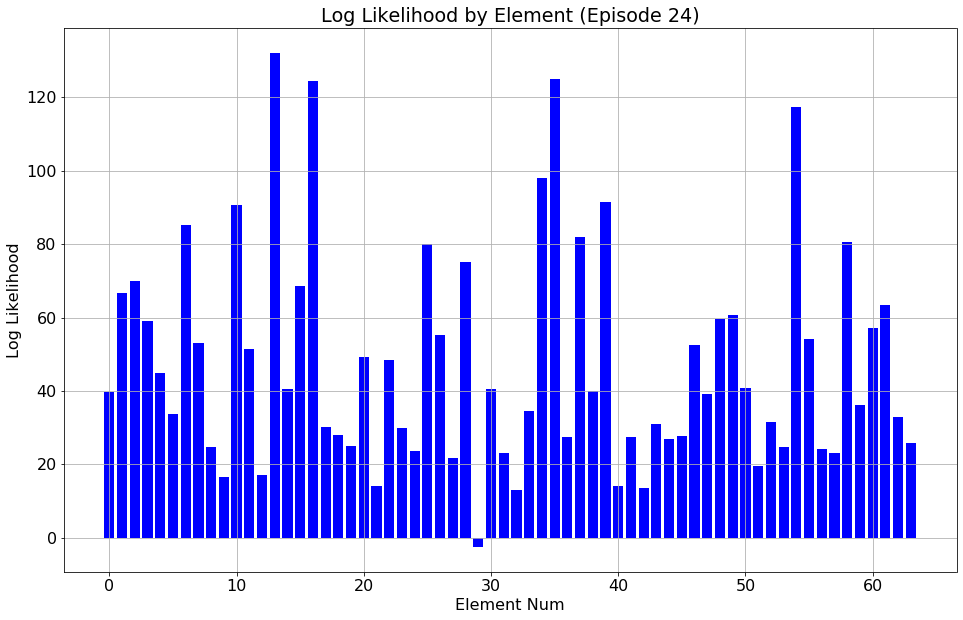

In [45]:
# Bar chart - log likelihood by element
fig, ax = model.plot_bar('log_like', sorted=False)

In [ ]:
# Bar chart: hits
fig, ax = model.plot_bar('hits', sorted=False)

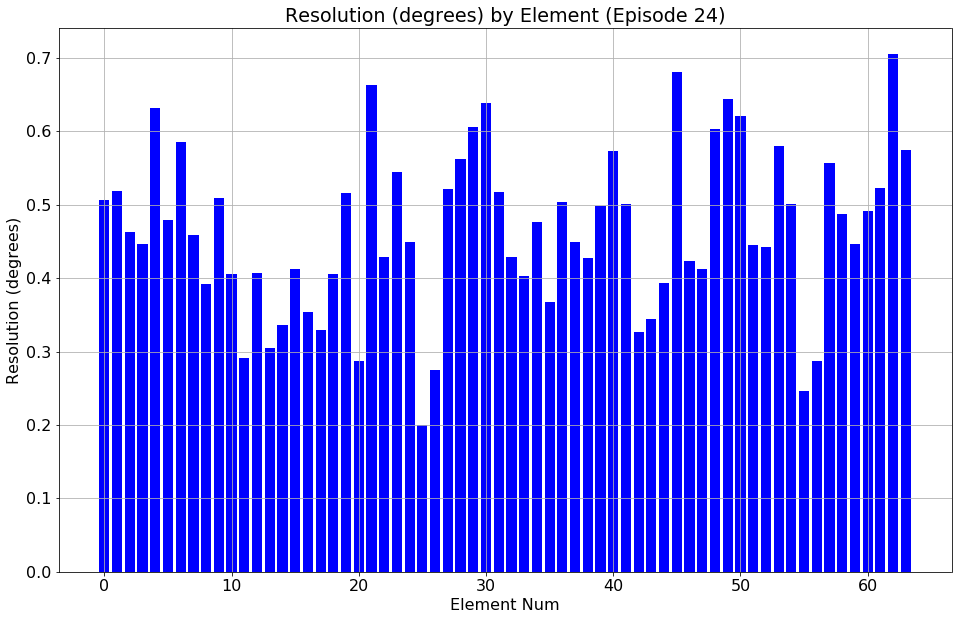

In [46]:
# Bar chart: log likelihood
fig, ax = model.plot_bar('R_deg', sorted=False)

In [ ]:
# Learning curve: log likelihood
fig, ax = model.plot_hist('log_like')

In [ ]:
# Learning curve: hits
fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [ ]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [ ]:
# Review fitted elements including nearest asteroid
elts_fit

In [ ]:
q_norm = elt_q_norm(elts=elts_fit, ast_num=elts_fit.nearest_ast_num)
elts_fit['nearest_ast_q_norm'] = q_norm

In [ ]:
# Review asteroids nearest to the fitted elements
elts_near

In [ ]:
# Find nearest asteroid to fitted elements - search on Covariance metric
elts_fit, elts_near = model.nearest_ast(search_type='cov')

In [ ]:
# # Filter for only the good ones
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec < 60)
# elts_fit[mask]

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# model.elts_near_ast

In [ ]:
model.elts_fit

In [ ]:
q_norm = elt_q_norm(elts=model.elts_fit, ast_num=model.elts_fit.nearest_ast_num)

In [ ]:
mask = q_norm < 1
np.round(q_norm[mask], 2)

In [ ]:
ast_elt_near_cov = nearest_ast_elt_cov(elts=model.elts_fit)

In [ ]:
ast_elt_near_cov

In [ ]:
dElt = ast_elt_near_cov[cols] - elts_fit[cols]
dElt[62:63]

In [ ]:
X_ast = elts_to_X_cov(ast_elt_near_cov)
U_ast = np.dot(X_ast, beta)
# np.linalg.norm(U_ast, axis=1)
X_ast[62]

In [ ]:
U_ast[62]

In [ ]:
X_elt = elts_to_X_cov(elts_fit)
U_elt = np.dot(U_ast, beta)
X_elt[62:63]

In [ ]:
U_elt[62]

In [ ]:
dU = U_elt - U_ast

In [ ]:
dU[62]

In [ ]:
np.linalg.norm(dU[62])

In [ ]:
ast_elt_near_cov[cols].loc[62].values

In [ ]:
# covariance type difference vs. nearest asteroid element
from nearest_asteroid import beta, X_beta, elts_to_X_cov

In [ ]:
ast_elt

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='a', is_log=True, elt_num=None)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error(elt_name='e', is_log=True, elt_num=None)